In [1]:
#from block_sync_class import *
from BlockSync2 import *
from bokeh.plotting import figure, show
import pickle
import time
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats
from lxml import etree
import open_ephys.analysis as oea
import pandas as pd

In [2]:
block = BlockSync(animal_call='PV_24',
                  experiment_date='23_12_2021',
                  block_num='1',
                  path_to_animal_folder='D:\experiments')

instantiated block number 1 at Path: D:\experiments\PV_24\23_12_2021\block_1
The sample rate for block 1 is 20000 Hz


In [3]:
block.handle_eye_videos()
block.handle_arena_files()
block.parse_open_ephys_events()



converting videos...
converting files: ['D:\\experiments\\PV_24\\23_12_2021\\block_1\\eye_videos\\LE\\PV24_EE_1_640x480_60hz_experiment_1_recording_0\\PV24_EE_1.h264', 'D:\\experiments\\PV_24\\23_12_2021\\block_1\\eye_videos\\RE\\PV24_EE_1_640x480_60hz_experiment_1_recording_0\\PV24_EE_1.h264']
The file D:\experiments\PV_24\23_12_2021\block_1\eye_videos\RE\PV24_EE_1_640x480_60hz_experiment_1_recording_0\PV24_EE_1.mp4 already exists, no conversion necessary
Validating videos...
The video named PV24_EE_1_LE.mp4 has reported 12563 frames and has 12563 frames, it has dropped 0 frames
The video named PV24_EE_1.mp4 has reported 12559 frames and has 12559 frames, it has dropped 0 frames
Arena video Names:
back_20211223_183620.mp4
left_20211223_183620.mp4
right_20211223_183620.mp4
top_20211223_183620.mp4
events.csv file already exists
L_eye_TTL was not identified as Arena_TTL
[ 1327 14179]
arena first frame timestamp: 311097465
arena end frame timestamp: 315479115
R_eye_TTL was not identified 

In [4]:
block.synchronize_block()

In [5]:
block.create_eye_brightness_df(threshold_value=250)

working on video D:\experiments\PV_24\23_12_2021\block_1\eye_videos\LE\PV24_EE_1_640x480_60hz_experiment_1_recording_0\PV24_EE_1_LE.mp4
done, frame_val_list contains 1 objects
working on video D:\experiments\PV_24\23_12_2021\block_1\eye_videos\RE\PV24_EE_1_640x480_60hz_experiment_1_recording_0\PV24_EE_1.mp4
done, frame_val_list contains 1 objects
creating D:\experiments\PV_24\23_12_2021\block_1\analysis/eye_brightness_df.csv


208.98907


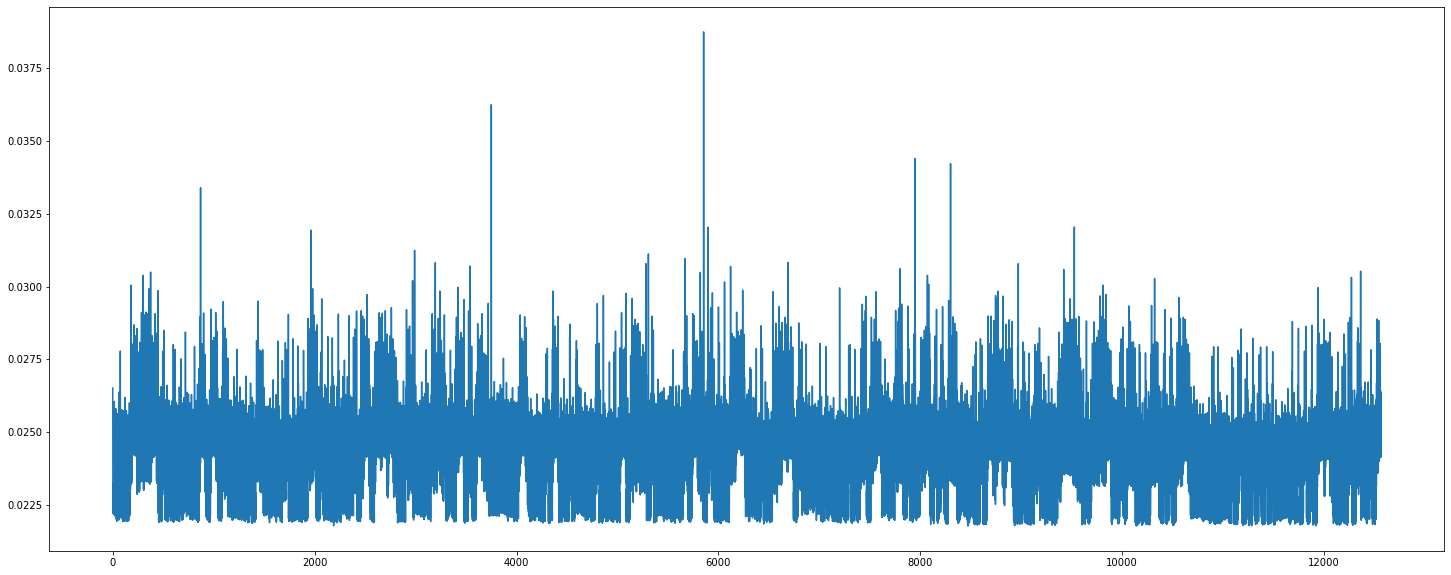

In [55]:
# here I will try and understand the synchronization step function (i.e why don't left and right align perfectly
#first, understand the step between actual frame and ttl for the two different eyes
timestamps_filename = [i for i in os.listdir(block.l_e_path) if 'timestamps.csv' in i][0]
path_to_timestamp_l = block.l_e_path / timestamps_filename
df = pd.read_csv(path_to_timestamp_l)
diff_list = df[df.columns[1]] - df[df.columns[0]]
interval = df.iloc[-1]['# frame timestamp'] - df.iloc[0]['# frame timestamp']
print(interval/1000000)
sample_rate_for_eye_videos = 1000000
####
diff_list = diff_list/1000000
f, axs = plt.subplots(1,1,figsize=(25,10))
axs.plot(diff_list)



In [29]:
(block.blocksync_df.iloc[-1].name - block.blocksync_df.iloc[0].name) / 20000

208.90285

In [56]:
#create bokeh plot:
x_axis = block.eye_brightness_df.index.values
columns = ['L_values','R_values']
bokeh_fig = figure(title='eye_brightness_per_frame',
                   x_axis_label='sample_time',
                   y_axis_label='mean_eye_vid_brightness(Zscore)',
                   plot_width=1500,
                   plot_height=700)
color_list = ['green', 'red','teal']
for ind,col in enumerate(columns):
    bokeh_fig.line(x_axis,block.eye_brightness_df[col],
                   legend_label=col,
                   line_width=1,
                   line_color=color_list[ind])
show(bokeh_fig)

In [70]:
# create_arena_brightness_df built here::
threshold_value = 30
if block.le_frame_val_list is None:
    block.le_frame_val_list = block.produce_frame_val_list(block.le_videos, threshold_value)
if block.re_frame_val_list is None:
    block.re_frame_val_list = block.produce_frame_val_list(block.re_videos, threshold_value)

block.l_eye_values = stats.zscore(block.le_frame_val_list[0][1])
block.r_eye_values = stats.zscore(block.re_frame_val_list[0][1])

cols = [i for i in block.blocksync_df.columns if 'Arena' not in i]
new_l_col = 'L_value'
new_r_col = 'R_value'
for col in cols:
    print(f'working on columns {col}')
    for i in tqdm(block.blocksync_df[col]):
        index = block.blocksync_df.query(f'{col} == {i}').index[0]
        if 'L' in col:
            block.blocksync_df.loc[index,new_l_col] = block.l_eye_values[int(i)]
        elif 'R' in col:
            block.blocksync_df.loc[index,new_r_col] = block.r_eye_values[int(i)]


  0%|          | 29/71891 [00:00<08:25, 142.17it/s]

working on columns L_eye_frame


  0%|          | 15/71891 [00:00<08:18, 144.27it/s]

working on columns R_eye_frame


  0%|          | 22/71891 [00:00<01:34, 758.65it/s]

working on columns L_value


UndefinedVariableError: name 'nan' is not defined

In [33]:
# create_arena_brightness_df built here:: THIS SHOULD BE A BETTER WAY
threshold_value = 30
if block.le_frame_val_list is None:
    block.le_frame_val_list = block.produce_frame_val_list(block.le_videos, threshold_value)
if block.re_frame_val_list is None:
    block.re_frame_val_list = block.produce_frame_val_list(block.re_videos, threshold_value)

block.l_eye_values = stats.zscore(block.le_frame_val_list[0][1])
block.r_eye_values = stats.zscore(block.re_frame_val_list[0][1])

cols = [i for i in block.blocksync_df.columns if 'Arena' not in i]
new_l_col = 'L_value'
new_r_col = 'R_value'



# for col in cols:
#     print(f'working on columns {col}')
#     for i in tqdm(block.blocksync_df[col]):
#         index = block.blocksync_df.query(f'{col} == {i}').index[0]
#         if 'L' in col:
#             block.blocksync_df.loc[index,new_l_col] = block.l_eye_values[int(i)]
#         elif 'R' in col:
#             block.blocksync_df.loc[index,new_r_col] = block.r_eye_values[int(i)]

# #This was very iterative, better to work with pandas series:
# for col in cols:
#     s = block.blocksync_df[col]
#     if 'R' in col:
#         vs = block.r_eye_values[[s.values.astype(int)]]
#         to_concat_R = pd.Series(data=vs,index=s.index,name='R_value')
#     elif 'L' in col:
#         vs = block.l_eye_values[[s.values.astype(int)]]
#         to_concat_L = pd.Series(data=vs,index=s.index,name='L_value')
#
# block.eye_brightness_df = pd.concat([block.blocksync_df,to_concat_L,to_concat_R],axis=1)

df = block.blocksync_df.merge(
    right=pd.DataFrame(block.l_eye_values, columns=['L_values']).reset_index(),
    how='left',
    left_on='L_eye_frame',
    right_on='index')

df = df.merge(
    right=pd.DataFrame(block.r_eye_values, columns=['R_values']).reset_index(),
    how='left',
    left_on='R_eye_frame',
    right_on='index')
df = df.drop(labels=['index_x','index_y'],axis=1)
df.index = block.blocksync_df.index
df

,Arena_frame,L_eye_frame,R_eye_frame,index_x,L_values,index_y,R_values
Arena_TTL,,,,,,,
311240361.0,419,0,4,0,-0.949381,4.0,1.257309
311240702.0,420,2,5,2,-0.945408,5.0,1.260595
311241043.0,421,3,6,3,-0.942863,6.0,1.254224
311241384.0,422,4,8,4,-0.951587,8.0,1.256650
311241725.0,423,5,9,5,-0.949012,9.0,1.255759
...,...,...,...,...,...,...,...
315417054.0,12669,12553,12557,12553,1.262901,12557.0,-0.877492
315417394.0,12670,12554,12558,12554,1.265334,12558.0,-0.873460
315417736.0,12671,12555,12559,12555,1.264351,NaN,NaN


In [28]:
block.blocksync_df.index


Float64Index([311240361.0, 311240702.0, 311241043.0, 311241384.0, 311241725.0,
              311242066.0, 311242407.0, 311242748.0, 311243089.0, 311243431.0,
              ...
              315415349.0, 315415689.0, 315416030.0, 315416371.0, 315416713.0,
              315417054.0, 315417394.0, 315417736.0, 315418077.0, 315418418.0],
             dtype='float64', name='Arena_TTL', length=12255)

In [8]:
#but also built here::
print(s.values.astype(int))
print(block.r_eye_values)

[    4     5     6 ... 12559 12560 12561]
[ 1.25768391  1.25578743  1.25733741 ... -0.88560091 -0.87749215
 -0.87345973]


In [10]:
# produce_drift_report built here::
# create the column_map automatically
l_key = [i for i in block.blocksync_df.columns if 'L' in i]
r_key = [i for i in block.blocksync_df.columns if 'R' in i]
l_values = [i for i in block.oe_events.columns if 'L_e' in i]
r_values = [i for i in block.oe_events.columns if 'R_e' in i]
l_values.append('L_eye_slip')
r_values.append('R_eye_slip')
print(l_values)

col_map = {
    l_key[0] : l_values,
    r_key[0] : r_values
}
acc_report = block.blocksync_df.copy(deep=True)
for col in ['L_eye_frame','R_eye_frame']:
    acc_report.insert(loc=0,column=column_map[col][2],value=np.nan)
    print(f'working on {col}...')
    for i,t in tqdm(enumerate(block.blocksync_df.index)):
        eye_frame = block.blocksync_df[col].iloc[i]
        frame_col = column_map[col][1]
        TTL_col = column_map[col][0]
        eye_loc = block.oe_events.query(f"{frame_col} == {eye_frame}").index[0]
        eye_timestamp = block.oe_events.loc[eye_loc, TTL_col]
        large = max(eye_timestamp, t)
        small = min(eye_timestamp, t)
        abs_diff = abs(large - small)
        acc_report.at[t,column_map[col][2]] = abs_diff
    #
 slip_list.append(eye_timestamp)



230it [00:00, 1132.19it/s]

working on L_eye_frame...


12255it [00:10, 1147.70it/s]
235it [00:00, 1153.35it/s]

working on R_eye_frame...


12255it [00:10, 1151.75it/s]


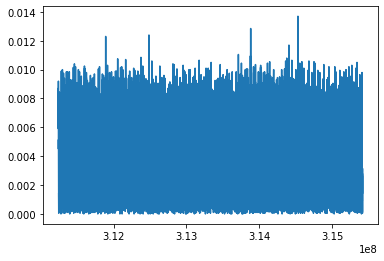

In [22]:
plt.plot(acc_report.R_eye_slip / 20000)

In [42]:
col = 'L_eye_frame'
frame_col = column_map[col][1]
TTL_col = column_map[col][0]
#block.oe_events.L_eye_TTL.loc[block.oe_events.query("L_eye_TTL_frame == 1").index[0]] -- this one worked
timestamp = block.oe_events.query(f"{frame_col} == {eye_frame}").index[0]

3507

In [50]:
block.oe_events

,L_eye_slip,L_eye_TTL,L_eye_TTL_frame,Arena_TTL,Arena_TTL_frame,R_eye_TTL,R_eye_TTL_frame
0,NaN,NaN,NaN,310604551.0,NaN,NaN,NaN
2,NaN,NaN,NaN,310604892.0,NaN,NaN,NaN
4,NaN,NaN,NaN,310605233.0,NaN,NaN,NaN
6,NaN,NaN,NaN,310605574.0,NaN,NaN,NaN
8,NaN,NaN,NaN,310605915.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...
79070,NaN,NaN,NaN,315598925.0,NaN,NaN,NaN
79072,NaN,NaN,NaN,315599266.0,NaN,NaN,NaN
79074,NaN,NaN,NaN,315599607.0,NaN,NaN,NaN
79076,NaN,NaN,NaN,315599948.0,NaN,NaN,NaN


In [7]:
# synchronize_block built here::
start_time = max([block.l_vid_first_t, block.arena_vid_first_t, block.r_vid_first_t])
end_time = min([block.arena_vid_last_t, block.r_vid_last_t, block.l_vid_last_t])
# create a loop to go over all arena times between start and end times:
#block.oe_events.query('@start_time < Arena_TTL< @end_time or Arena_TTL!=Arena_TTL') # This line has the important trick with nans: in python, a nan value is not equal to itself!!!
arena_tf = block.oe_events.query('@start_time < Arena_TTL < @end_time')[['Arena_TTL', 'Arena_TTL_frame']]
r_eye_tf = block.oe_events.query('@start_time < Arena_TTL < @end_time or Arena_TTL != Arena_TTL')[['R_eye_TTL', 'R_eye_TTL_frame']]
r_eye_tf = r_eye_tf[np.invert(np.isnan(r_eye_tf.R_eye_TTL.values))] # this removes nan values
l_eye_tf = block.oe_events.query('@start_time < Arena_TTL < @end_time or Arena_TTL != Arena_TTL')[['L_eye_TTL', 'L_eye_TTL_frame']]
l_eye_tf = l_eye_tf[np.invert(np.isnan(l_eye_tf.L_eye_TTL.values))] # this removes nan values
blocksync_df = pd.DataFrame(columns=['Arena_frame','L_eye_frame', 'R_eye_frame'], index=arena_tf.Arena_TTL)
for i,t in enumerate(arena_tf.Arena_TTL):
    arena_frame = arena_tf.Arena_TTL_frame.iloc[i]
    l_eye_frame = l_eye_tf['L_eye_TTL_frame'].iloc[get_closest_frame(t,l_eye_tf['L_eye_TTL'])]
    r_eye_frame = r_eye_tf['R_eye_TTL_frame'].iloc[get_closest_frame(t,r_eye_tf['R_eye_TTL'])]
    blocksync_df.loc[t] = [arena_frame, l_eye_frame, r_eye_frame]
blocksync_df

,Arena_frame,L_eye_frame,R_eye_frame
Arena_TTL,,,


In [29]:
#find first last frame built here::
s = ~pd.isna(block.oe_events['L_eye_TTL_frame'])
df_first_loc = s[s==True].index[0]
df_last_loc = s[s==True].index[-1]
print(block.oe_events['L_eye_TTL'].loc[df_first_loc])

321583151.0


In [62]:
def get_closest_frame(timestamp, vid_timeseries):
    """
    This function extracts a frame from a series so that it is as close as possible to a given timestamp
    :param timestamp: The time to match a frame to
    :param vid_timeseries: The time frames series to look at for a match
    :return: index_of_lowest_diff , accuracy of match (if requested)
    """
    array = np.abs((vid_timeseries.to_numpy()) - timestamp)
    index_of_lowest_diff = np.argmin(array)
    return index_of_lowest_diff

In [9]:
block.oe_events

,L_eye_TTL,L_eye_TTL_frame,Arena_TTL,Arena_TTL_frame,R_eye_TTL,R_eye_TTL_frame
0,NaN,NaN,310604551.0,NaN,NaN,NaN
2,NaN,NaN,310604892.0,NaN,NaN,NaN
4,NaN,NaN,310605233.0,NaN,NaN,NaN
6,NaN,NaN,310605574.0,NaN,NaN,NaN
8,NaN,NaN,310605915.0,NaN,NaN,NaN
...,...,...,...,...,...,...
79070,NaN,NaN,315598925.0,NaN,NaN,NaN
79072,NaN,NaN,315599266.0,NaN,NaN,NaN
79074,NaN,NaN,315599607.0,NaN,NaN,NaN
79076,NaN,NaN,315599948.0,NaN,NaN,NaN


In [10]:
df = pd.read_csv(r'D:\experiments\PV_24\23_12_2021\block_1\oe_files\PV24_EE_1_2021-12-23_18-35-57\events.csv')
channel_names = block.channeldict
channels = np.unique(df['channel'].to_numpy(copy=True))
df_onstate = df[df['state'] == 1]  # cut the df to represent only rising edges
df_offstate = df[df['state'] == 0]  # This one is important for the ON/OFF signal of the arena
ls = []
for chan in channels:
    Sname = channel_names[chan]
    s = pd.Series(df_onstate['timestamp'][df_onstate['channel'] == chan], name=Sname)
    if Sname == 'Arena_TTL':
        diff_series = np.diff(s)
        diff_mode = stats.mode(diff_series)[0][0]
        #print(s)
        #print(np.where(diff_series > 10 * diff_mode))
        arena_start_stop = np.where(diff_series > 10 * diff_mode)[0]
        arena_start_timestamp = s.iloc[arena_start_stop[0]+1]
        arena_end_timestamp = s.iloc[arena_start_stop[1]]
    s_counter = pd.Series(data=np.arange(len(s), dtype='int16'), index=s.index.values, name=Sname + '_frame')
    ls.append(s)
    ls.append(s_counter)
open_ephys_events = pd.concat(ls, axis=1)

# use arena start_stop to clean TTLs counted before video starts and after it ends
open_ephys_events['Arena_TTL_frame'] = open_ephys_events['Arena_TTL_frame'] - (arena_start_stop[0] + 1)
open_ephys_events['Arena_TTL_frame'][open_ephys_events['Arena_TTL_frame'] < 0] = np.nan
open_ephys_events['Arena_TTL_frame'][open_ephys_events['Arena_TTL'] > arena_end_timestamp] = np.nan

# This bit of code finds the first and last frames of the eye videos in open-ephys timestamps
R_eye_end_timestamp = open_ephys_events['R_eye_TTL'].loc[open_ephys_events['R_eye_TTL_frame'].idxmax()]
R_eye_start_timestamp = open_ephys_events['R_eye_TTL'].loc[open_ephys_events['R_eye_TTL_frame'].idxmin()]
L_eye_end_timestamp = open_ephys_events['L_eye_TTL'].loc[open_ephys_events['L_eye_TTL_frame'].idxmax()]
L_eye_start_timestamp = open_ephys_events['L_eye_TTL'].loc[open_ephys_events['L_eye_TTL_frame'].idxmin()]


In [49]:
open_ephys_events['R_eye_TTL'].loc[open_ephys_events['R_eye_TTL_frame'].idxmin()]


311238973.0

In [11]:
open_ephys_events

,L_eye_TTL,L_eye_TTL_frame,Arena_TTL,Arena_TTL_frame,R_eye_TTL,R_eye_TTL_frame
0,NaN,NaN,310604551.0,NaN,NaN,NaN
2,NaN,NaN,310604892.0,NaN,NaN,NaN
4,NaN,NaN,310605233.0,NaN,NaN,NaN
6,NaN,NaN,310605574.0,NaN,NaN,NaN
8,NaN,NaN,310605915.0,NaN,NaN,NaN
...,...,...,...,...,...,...
79070,NaN,NaN,315598925.0,NaN,NaN,NaN
79072,NaN,NaN,315599266.0,NaN,NaN,NaN
79074,NaN,NaN,315599607.0,NaN,NaN,NaN
79076,NaN,NaN,315599948.0,NaN,NaN,NaN


In [32]:
block.create_arena_brightness_df(250, export=True)

AttributeError: 'BlockSync' object has no attribute 'create_arena_brightness_df'

In [12]:
block.update_arena_bdf()

In [13]:
block.create_eye_brightness_df(30)

working on video D:\experiments\PV_24\23_12_2021\block_1\eye_videos\LE\PV24_EE_1_640x480_60hz_experiment_1_recording_0\PV24_EE_1_LE.mp4
done, frame_val_list contains 1 objects
working on video D:\experiments\PV_24\23_12_2021\block_1\eye_videos\RE\PV24_EE_1_640x480_60hz_experiment_1_recording_0\PV24_EE_1.mp4
done, frame_val_list contains 1 objects


In [14]:
block.eye_brightness_df

,L_eye_TTL,R_eye_TTL
31788.700000,-1.328823,-0.492117
31805.366667,-1.321568,-0.489684
31822.033333,-1.320279,-0.488336
31838.700000,-1.318615,-0.487730
31855.366667,-1.319954,-0.486838
...,...,...
239622.033333,0.933780,-1.048594
239638.700000,0.934093,-1.047509
239655.366667,0.935828,-1.053194
239672.033333,0.933978,-1.050372


In [15]:
block.validate_eye_synchronization()

In [16]:
block.synchronize_by_led_blink(threshold_value_for_eyes=30)

-4.0
-3.8
-3.5999999999999996
-3.3999999999999995
-3.1999999999999993
-2.999999999999999
-2.999999999999999
bad arena brightness df, manual synchronization required
The suspect list is: [8931, 8932, 8933, 8934, 8935, 8936, 8937, 8938, 8939, 8940, 8941, 8942, 8943, 8944, 8945, 8946, 8947, 8948, 8949, 8950, 8951, 8952, 8953, 8954, 8955, 8956, 8957, 8958, 8959, 8960, 8961, 8962, 8963, 8964, 8965, 8966, 8967, 8968, 8969, 8970, 8971, 8972, 8973, 8974, 8975, 8976, 8977, 8978, 8979, 8980, 8981, 8982, 8983, 8984, 8985, 8986, 8987, 8988, 8989, 8990, 8991, 8992, 8993, 8994, 8995, 8996, 8997, 8998, 8999, 9000, 9001, 9002, 9003, 9004, 9005, 9006, 9007, 9008, 9009, 9010, 9011, 9012, 9013, 9014, 9015, 9016, 9017, 9018, 9019, 9020, 9021, 9022, 9023, 9024, 9025, 9026, 9027, 9028, 9029, 9030, 9031, 9032, 9033, 9034, 9035, 9036, 9037, 9038, 9039, 9040, 9041, 9042, 9043, 9044, 9045, 9046, 9047, 9048, 9049, 9050, 9051, 9052, 9053, 9054, 9055, 9056, 9057, 9058, 9059, 9060, 9061, 9062, 9063, 9064, 9065, 906

In [20]:
block.r_eye_values[block.synced_videos[f'R_eye_TTL'].values.astype(int)][0:len(block.anchor_signal)]

IndexError: index 12559 is out of bounds for axis 0 with size 12559

In [68]:
block.synced_videos[f'R_eye_TTL'].values.astype(int)

array([    4,     5,     6, ..., 12559, 12560, 12561])

In [66]:
r_eye_collection = []

for i in block.synced_videos['R_eye_TTL']:
    #block.r_eye_values
df = pd.DataFrame(index=block.anchor_signal)
df

""
31788.700000
31805.366667
31822.033333
31838.700000
31855.366667
...
240622.033333
240638.700000
240655.366667
240672.033333


In [12]:
session = oea.Session(block.oe_path)
len(session.recordings[0].continuous[0].timestamps) == len(session.recordings[0].continuous[0].samples)

True

In [ ]:
def get_sample_rate(block):
    xml_tree = etree.parse(str(block.settings_xml))
    xml_root = xml_tree.getroot()
    for child in xml_root.iter():
        if child.tag == 'EDITOR':
            try:
                sample_rate = int(float(child.attrib['SampleRateString'][:4])*1000)
                print(sample_rate)
            except KeyError:
                continue

In [37]:
p = r'D:\experiments\PV_24\23_12_2021\block_1\oe_files\PV24_EE_1_2021-12-23_18-35-57\Record Node 101\settings.xml'

t = etree.parse(p)
root = t.getroot()
count = 0
for child in root.iter():
    print(child)
    if child.tag == 'EDITOR':
        try:
            print(child.attrib['SampleRateString'])
            print(child.attrib.keys())
        except KeyError:
            print('no sample rate key')
    #print(child.tag)
    #print(child.attrib)
    #print(child.keys())

<Element SETTINGS at 0x203e93a05c0>
<Element INFO at 0x203e93a0ec0>
<Element VERSION at 0x203e8dfb580>
<Element PLUGIN_API_VERSION at 0x203e93a03c0>
<Element DATE at 0x203e93a0ec0>
<Element OS at 0x203e8dfb580>
<Element MACHINE at 0x203e93a03c0>
<Element SIGNALCHAIN at 0x203e93a0ec0>
<Element PROCESSOR at 0x203e6334c40>
<Element CHANNEL_INFO at 0x203e93a03c0>
<Element CHANNEL at 0x203e93a0ec0>
<Element CHANNEL at 0x203e8dfb580>
<Element CHANNEL at 0x203e93a03c0>
<Element CHANNEL at 0x203e93a0ec0>
<Element CHANNEL at 0x203e6334c40>
<Element CHANNEL at 0x203e93a03c0>
<Element CHANNEL at 0x203e93a0ec0>
<Element CHANNEL at 0x203e8dfb580>
<Element CHANNEL at 0x203e93a03c0>
<Element CHANNEL at 0x203e93a0ec0>
<Element CHANNEL at 0x203e6334c40>
<Element CHANNEL at 0x203e93a03c0>
<Element CHANNEL at 0x203e93a0ec0>
<Element CHANNEL at 0x203e8dfb580>
<Element CHANNEL at 0x203e93a03c0>
<Element CHANNEL at 0x203e93a0ec0>
<Element CHANNEL at 0x203e6334c40>
<Element CHANNEL at 0x203e93a03c0>
<Element

In [44]:
session = analysis.Session(r'D:\experiments\PV_24\23_12_2021\block_1\oe_files\PV24_EE_1_2021-12-23_18-35-57')


In [90]:
f = open(r'D:\experiments\PV_24\23_12_2021\block_1\oe_files\PV24_EE_1_2021-12-23_18-35-57\Record Node 101\100_1.continuous', 'rb')
for l in f.readlines(500):
    print(l)
f.close()

b"header.format = 'Open Ephys Data Format'; \n"
b'header.version = 0.5; \n'
b'header.header_bytes = 1024;\n'
b"header.description = 'each record contains one 64-bit timestamp, one 16-bit sample count (N), 1 uint16 recordingNumber, N 16-bit samples, and one 10-byte record marker (0 1 2 3 4 5 6 7 8 255)'; \n"
b"header.date_created = '23-Dec-2021 18:35:57';\n"
b"header.channel = 'CH1';\n"
b"header.channelType = 'Continuous';\n"
b'header.sampleRate = 20000;\n'
b'header.blockLength = 1024;\n'
b';\n'
b'header.bitVolts = 0.195;\n'
b"                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [3]:
block.handle_arena_files()

Arena video Names:
back_20211223_183620.mp4
left_20211223_183620.mp4
right_20211223_183620.mp4
top_20211223_183620.mp4


In [19]:
def get_block_sample_rate(block):
    p = (block.block_path / 'oe_files' / block.oe_dirname)
    dirs = os.listdir(p)
    record_node_name = [i for i in dirs if (p/i).is_dir()][0]
    record_node_path = p/record_node_name
    t = etree.parse((record_node_path / 'settings.xml').as_posix())
    root = t.getroot()
    for child in root.iter():
        if child.tag == 'EDITOR':
            try:
                samplrate_string = child.attrib['SampleRateString']
                samplerate = float(samplrate_string[:3])
            except KeyError:
                continue
    return samplerate*1000

In [21]:
sample_rate = get_block_sample_rate(block)


20000.0


In [5]:
import open_ephys.analysis as oe

p = block.block_path / 'oe_files'
session = oe.Session(str(p / os.listdir(p)[0]))
events = session.recordnodes[0].recordings[0].events

sec_based_events = events.timestamp.values / 20000

In [22]:
block.handle_eye_videos()

converting videos...
converting files: ['D:\\experiments\\PV_24\\23_12_2021\\block_1\\eye_videos\\LE\\PV24_EE_1_640x480_60hz_experiment_1_recording_0\\PV24_EE_1.h264', 'D:\\experiments\\PV_24\\23_12_2021\\block_1\\eye_videos\\RE\\PV24_EE_1_640x480_60hz_experiment_1_recording_0\\PV24_EE_1.h264']
The file D:\experiments\PV_24\23_12_2021\block_1\eye_videos\RE\PV24_EE_1_640x480_60hz_experiment_1_recording_0\PV24_EE_1.mp4 already exists, no conversion necessary
Validating videos...
The video named PV24_EE_1_LE.mp4 has reported 12563 frames and has 12563 frames, it has dropped 0 frames
The video named PV24_EE_1.mp4 has reported 12559 frames and has 12559 frames, it has dropped 0 frames


In [23]:
block.synchronize_arena_timestamps()

Synchronizing the different arena videos


100%|██████████| 12851/12851 [00:12<00:00, 1006.82it/s]

The anchor video used was "back_20211223_183620.mp4"


In [24]:
block.create_arena_brightness_df(250,export=True)

arena brightness df already exists


In [25]:
block.import_open_ephys_events()

(array([ 1327, 14179], dtype=int64),)
The first block frame came from the L_eye_TTL
The last frame of the block came from L_eye_TTL


In [34]:
df = block.oe_events.sub(block.oe_events['Arena_TTL'].iloc[0])
df.reindex(index=range(len(df)))

,L_eye_TTL,Arena_TTL,R_eye_TTL
0,NaN,0.00000,NaN
1,NaN,NaN,NaN
2,NaN,0.01705,NaN
3,NaN,NaN,NaN
4,NaN,0.03410,NaN
...,...,...,...
39535,NaN,NaN,132.5016
39536,NaN,NaN,NaN
39537,NaN,NaN,NaN
39538,NaN,132.50860,NaN


In [6]:
block.handle_arena_files()
block.handle_eye_videos()
block.synchronize_arena_timestamps()
block.create_arena_brightness_df(250, export=True)

Arena video Names:
back_20211223_183620.mp4
left_20211223_183620.mp4
right_20211223_183620.mp4
top_20211223_183620.mp4
converting videos...
converting files: ['D:\\experiments\\PV_24\\23_12_2021\\block_1\\eye_videos\\LE\\PV24_EE_1_640x480_60hz_experiment_1_recording_0\\PV24_EE_1.h264', 'D:\\experiments\\PV_24\\23_12_2021\\block_1\\eye_videos\\RE\\PV24_EE_1_640x480_60hz_experiment_1_recording_0\\PV24_EE_1.h264']
The file D:\experiments\PV_24\23_12_2021\block_1\eye_videos\RE\PV24_EE_1_640x480_60hz_experiment_1_recording_0\PV24_EE_1.mp4 already exists, no conversion necessary
Validating videos...
The video named PV24_EE_1_LE.mp4 has reported 12565 frames and has 12563 frames, it has dropped 2 frames
The video named PV24_EE_1_LEDLC_resnet_50_Eye_Tracking_piplineMar1shuffle1_950000_labeled.mp4 has reported 12563 frames and has 12563 frames, it has dropped 0 frames
The video named PV24_EE_1.mp4 has reported 12561 frames and has 12559 frames, it has dropped 2 frames
The video named PV24_EE_1D

  1%|          | 113/12851 [00:00<00:11, 1129.99it/s]

Synchronizing the different arena videos


 69%|██████▉   | 8880/12851 [00:08<00:03, 1056.39it/s]


KeyboardInterrupt: 

In [5]:
block.import_open_ephys_events()
block.synchronize_block()
block.update_arena_bdf()
block.create_eye_brightness_df(30)

  1%|▏         | 180/13801 [00:00<00:07, 1799.51it/s]

The first block frame came from the Arena_video
The last frame came from the Arena Video
synchronizing 230.01318359375 seconds of videos...


100%|██████████| 13801/13801 [00:08<00:00, 1627.70it/s]


working on video D:\experiments\Animal_4\18_07_2021\block_7\eye_videos\LE\vstim_pv4_7_640x480_60hz_experiment_1_recording_0\vstim_pv4_7_LE.mp4
done, frame_val_list contains 1 objects
working on video D:\experiments\Animal_4\18_07_2021\block_7\eye_videos\RE\vstim_pv4_7_640x480_60hz_experiment_1_recording_0\vstim_pv4_7.mp4
done, frame_val_list contains 1 objects


In [5]:
block.validate_eye_synchronization()

In [6]:
block.synced_videos_validated

In [7]:
block.synchronize_by_led_blink(threshold_value_for_eyes=30,arena_vid_to_use=block.arena_vidnames[3])

-4.0
-3.8
-3.5999999999999996
-3.3999999999999995
-3.1999999999999993
-2.999999999999999
-2.799999999999999
-2.5999999999999988
-2.3999999999999986
-2.1999999999999984
-1.9999999999999984
-1.9999999999999984
The suspect list is: [10907]
the search range is range(10857, 10957)
index inside range = (array([53, 54], dtype=int64),)
threshold used: -2
done, left ind is : 10910
index inside range = (array([50, 51], dtype=int64),)
threshold used: -3
done, right ind is : 10907
right eye drift is 0 frames
left eye drift is 3 frames
correcting synced_videos...
The method intends to move the right eye video 0 frames and the 
Left video 3


In [8]:
block.create_synced_videos_validated()

In [9]:
topvid = str(block.arena_videos[3])
backvid = str(block.arena_videos[0])
re_vid = block.re_videos[0]
le_vid = block.le_videos[0]

In [ ]:
block.create_synced_video('4vid_concatl_block7',
                          re_vid,
                          le_vid,
                          topvid,
                          backvid,block.block_starts,block.block_ends,overlay_frame_numbers=False)

In [37]:
ts_df = pd.DataFrame(block.ts_dict)
ttl_breaks = np.where(np.diff(ts_df.Arena_TTL.values) > 0.5)
ttl_breaks

(array([ 1068, 13945], dtype=int64),)

In [47]:

# determine which eye camera shot last:
if block.ts_dict['L_eye_TTL'].iloc[-1] - block.ts_dict['R_eye_TTL'].iloc[-1] < 0:
    first_to_end = 'L_eye_TTL'
else:
    first_to_end = 'R_eye_TTL'
# determine if the arena break in ttls happened before or after the last eye to start
arena_ends = block.ts_dict['Arena_TTL'][ttl_breaks[0][1]]
if block.ts_dict[first_to_end].iloc[-1] < arena_ends:
    block_ends = block.ts_dict[first_to_end].iloc[-1]
else:
    block_ens = arena_ends


1275.9451904296875

In [20]:
df = pd.read_csv(r'D:\experiments\PV_24\23_12_2021\block_1\oe_files\PV24_EE_1_2021-12-23_18-35-57\events.csv')
s = pd.Series((df.timestamp.values - df.timestamp.values[0])/20)
df['timestamp'] = s
df

,Unnamed: 0,channel,timestamp,processor_id,subprocessor_id,state
0,0,6,0.00,100,0,1
1,1,6,12.05,100,0,0
2,2,6,17.05,100,0,1
3,3,6,29.10,100,0,0
4,4,6,34.10,100,0,1
...,...,...,...,...,...,...
79074,79074,6,249752.80,100,0,1
79075,79075,6,249764.85,100,0,0
79076,79076,6,249769.85,100,0,1
79077,79077,6,249781.90,100,0,0


In [49]:
values = [0,50,100,0,20,30]
inds = np.array([0,0,1,2,3,4])
df = pd.DataFrame()
df.insert(loc=0,
          column='test',
          value=values[:3])
df

,test
0,0
1,50
2,100
